## Import nessacary libraries

In [48]:
from fastcore.xtras import load_pickle # to load saved output files
import pandas as pd # data science
import os # operating system
from glob import glob # path names
import matplotlib.pyplot as plt # plotting

The results of the experiment are saved in standarized pickle files in the 'out' folder

In [49]:
OUT_FOLDER = os.path.join('experiment', 'out')
print(f"Out folder of experiment: {OUT_FOLDER}")

Out folder of experiment: experiment/out


Create a list with all the output pickle files

In [50]:
if not os.path.exists(OUT_FOLDER):
    raise FileExistsError('Cannot find folder {}'.format(OUT_FOLDER))

all_res = glob(f'{OUT_FOLDER}/*.pkl')
print('Pickles found in {}: {}'.format(OUT_FOLDER, len(all_res)))


Pickles found in experiment/out: 12


Let's inspect one pickle file

In [51]:
INDEX = 0
pickle_example = load_pickle(all_res[INDEX])
for key, value in pickle_example.items():
    print(key, value)

results {'accuracy': 0.98, 'acc_macro': 0.98, 'racc': 0.5, 'kappa': 0.96, 'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]), 'f1_macro': 0.9799919967987194, 'f1_micro': 0.98, 'frac_valid': 1.0, 'all_y_true': [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0], 'all_y_pred': array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0]), 'valid_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'might_have_rounded_floats': False}
predictions [0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0
 0 1 1 1 0 0 0 0 1 0 1 1 0]
true [0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0
 0 1 

These are indeed the parameters and metrics saved in 'experiment/run_experiment_sh.py'

### Extract all the metrics and data from the pickle files

In [52]:
def get_all_results(all_res:list):
    result_metrics = []
    result_confusion_matrices = []

    for results in all_res:
        res_full = load_pickle(results)
        res = res_full['results']
        summary = {
            'size': res_full['train_size'],
            'representation': res_full['data_summary']['representation'],
            #'target': res_full['data_summary']['target'],
            'accuracy': res['accuracy'],
            'f1_macro': res['f1_macro'],
            'f1_micro': res['f1_micro'],
            'kappa': res['kappa'],
            'num_epochs': res_full['config']['tune_settings']['num_train_epochs'],
            'lr': res_full['config']['tune_settings']['learning_rate'],
            'bins': len(set(res['all_y_true'])),
            'test_size': len(res['all_y_true'])
        
        }
        confusion_matrix = {
            'all_y_true':res['all_y_true'],
            'all_y_pred':res['all_y_pred']
        }
        result_confusion_matrices.append(confusion_matrix)
        result_metrics.append(summary)
    
    return result_metrics, result_confusion_matrices

results_metrics, results_cms = get_all_results(all_res) # we get the metrics and the data required for creating the confusion matrices (see later)


With the pandas library, we can create an overview

In [53]:
compiled_res = pd.DataFrame(results_metrics)
grouped_res =compiled_res.groupby(['bins', 'num_epochs', 'representation', 'size']).agg(['mean', 'sem'])

In [54]:
grouped_res


accuracy            f1_macro            \
                                          mean       sem      mean       sem   
bins num_epochs representation  size                                           
2    4          sequence_prompt 100   0.593333  0.048074  0.501586  0.085873   
                                500   0.880000  0.020000  0.879006  0.020448   
                                1000  0.900000  0.011547  0.899880  0.011566   
                                5000  0.926667  0.035277  0.926487  0.035433   

                                      f1_micro               kappa            \
                                          mean       sem      mean       sem   
bins num_epochs representation  size                                           
2    4          sequence_prompt 100   0.593333  0.048074  0.186667  0.096148   
                                500   0.880000  0.020000  0.760000  0.040000   
                                1000  0.900000  0.011547  0.800000  0.023094   
                                5000  0.926667  0.035277  0.853333  0.070553   

                                          lr      test_size       
                                        mean  sem      mean  sem  
bins num_epochs representation  size                              
2    4          sequence_prompt 100   0.0003  0.0      50.0  0.0  
                                500   0.0003  0.0      50.0  0.0  
                                1000  0.0003  0.0      50.0  0.0  
                                5000  0.0003  0.0      50.0  0.0

## Plot the experiment

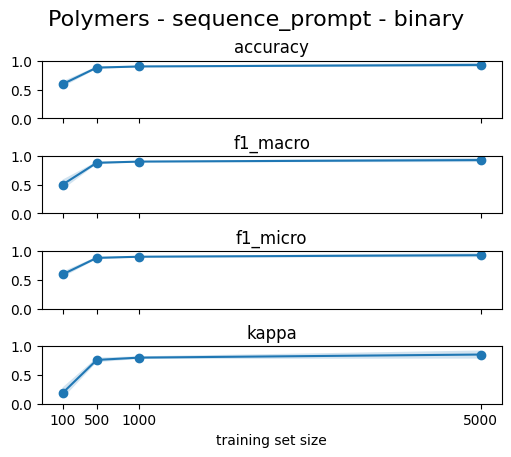

In [55]:
from scipy.stats import sem
from scipy.constants import golden

ONE_COL_WIDTH_INCH = 5
TWO_COL_WIDTH_INCH = 7.2

ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

BINS = 2
REPRESENTATION = 'sequence_prompt'
N_EPOCHS = 4

fig, ax = plt.subplots(4, 1,
                       figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH),
                       constrained_layout = True , 
                       sharex=True
                       )
 
for num_epochs in [N_EPOCHS]:
    # loop over metrics 
    for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
        # plot values and standard deviation
        ax[i].plot(
            grouped_res.loc[BINS, num_epochs,REPRESENTATION].index, 
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'],
            marker='o',
            label=f'{num_epochs} epochs'
        )
        ax[i].fill_between(
            grouped_res.loc[BINS, num_epochs,REPRESENTATION].index,
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'] - grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['sem'],
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'] + grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['sem'],
            alpha=0.2
        )
        
        ax[i].set_ylim(0,1)
        ax[i].set_xticks((list(compiled_res['size'].unique())))
        ax[i].set_title(metric)

ax[-1].set_xlabel('training set size')

fig.suptitle('Polymers - {} - {}'.format(REPRESENTATION, 'binary'), fontsize=16)

fig.savefig(f'AdhesiveFreeE-{REPRESENTATION}-binary-{BINS}bin-classification-results.pdf', bbox_inches='tight')